In [1]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available


✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [ ]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_good_acb.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path}")
else:
    print(f"✗ Model not found: {model_path}")

# # 1.2. Load dữ liệu 
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu từ vnstock...")
# df_raw = provider.get_ohlcv_data('SSI', '2021-12-14', '2024-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2022')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

df_processed_train = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\train\\bad_train_SSI.csv')
df_processed_train.rename(columns={'date': 'time'}, inplace=True)
df_processed_train['time'] = pd.to_datetime(df_processed_train['time']).dt.strftime('%d/%m/%Y')

df_processed_test = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\bad_test_SSI.csv')
df_processed_test.rename(columns={'date': 'time'}, inplace=True)
df_processed_test['time'] = pd.to_datetime(df_processed_test['time']).dt.strftime('%d/%m/%Y')

# Ghép dữ liệu: train trước rồi đến test (theo thời gian) thay vì dùng toán tử '+'
df_processed = pd.concat([df_processed_train, df_processed_test], ignore_index=True)
# Đảm bảo thứ tự thời gian tăng dần nếu chưa chắc chắn
_df_time = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
df_processed = df_processed.assign(_time=_df_time).sort_values('_time').drop(columns=['_time']).reset_index(drop=True)
print(f"✓ Merged train+test: {df_processed.shape} (train={df_processed_train.shape}, test={df_processed_test.shape})")
print(f"  Time range: {df_processed['time'].iloc[0]} -> {df_processed['time'].iloc[-1]}")

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

In [ ]:
# # 1.1. Load model SARSA
# qsa = Qsa(input_size=7, num_classes=11)
# model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

# if os.path.exists(model_path):
#     state_dict = torch.load(model_path, map_location=torch.device('cpu'))
#     qsa.load_state_dict(state_dict)
#     qsa.eval()
#     print(f"✓ Model loaded: {model_path}")
# else:
#     print(f"✗ Model not found: {model_path}")

# # 1.2. Load dữ liệu ACB
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu ACB từ vnstock...")
# df_raw = provider.get_ohlcv_data('ACB', '2012-12-14', '2022-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2013')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

# # 1.4. Khởi tạo MDP và chạy simulation
# mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

# def pi_deep(s, eps=0.0, greedy=True):
#     with torch.no_grad():
#         out_qsa = qsa(torch.Tensor(s).float()).squeeze()
#         action = out_qsa.argmax().item() - 5
#     return action

# # State ban đầu
# first_row = df_processed.iloc[0]
# state_init = [
#     float(first_row['close']),
#     mdp.balance_init,
#     0,
#     float(first_row['MACD']),
#     float(first_row['RSI']),
#     float(first_row['CCI']),
#     float(first_row['ADX'])
# ]

# # Chạy simulation
# print("\nĐang chạy simulation...")
# states, rewards, actions = mdp.simulate(
#     df_processed[1:].reset_index(drop=True), 
#     state_init, 
#     pi_deep, 
#     greedy=True, 
#     eps=0.0
# )

# print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
# print(f"  Total reward: {sum(rewards):.2f}")
# print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth

Đang lấy dữ liệu ACB từ vnstock...
LẤY DỮ LIỆU OHLCV TỪ VNSTOCK
📋 Danh sách mã: ['ACB']
📅 Khoảng thời gian: 2012-12-14 đến 2022-12-31
⏱️  Phiên: 1D
📡 Nguồn: VCI
--------------------------------------------------------------------------------
📡 Đang lấy dữ liệu cho ACB...
✅ ACB: 2622 dòng

KẾT QUẢ
✅ Tổng số dòng dữ liệu: 2,622
✅ Số mã thành công: 1

📋 Các cột dữ liệu:
   • date
   • open
   • high
   • low
   • close
   • volume
   • symbol

📊 Thống kê:
   • Số mã: 1
   • Khoảng thời gian: 2012-06-29 đến 2022-12-30

📄 Mẫu dữ liệu (10 dòng đầu):
         date  open  high   low  close   volume symbol
0  2012/06/29  3.61  3.61  3.58   3.60  1184300    ACB
1  2012/07/02  3.61  3.61  3.58   3.58   141000    ACB
2  2012/07/03  3.58  3.60  3.58   3.58   752300    ACB
3  2012/07/04  3.58  3.60  3.58   3.58   250500    ACB
4  2012/07/05  3.58  3.60  3.58   3.60   225500    ACB
5  2012/07/06  3.58  3.61  3.58   3.60   172900    A

In [3]:
# 2. Định nghĩa các hàm Multi-Step eXplanation (MSX)
from typing import List, Dict, Tuple

def compute_multi_step_return(rewards: List[float], t: int, H: int, gamma: float=0.99) -> float:
    """Tính G_t(H) = sum_{k=0}^{H-1} gamma^k R_{t+k}.
    Nếu vượt quá chiều dài rewards thì dừng sớm."""
    G = 0.0
    for k in range(H):
        idx = t + k
        if idx >= len(rewards):
            break
        G += (gamma ** k) * rewards[idx]
    return G


def build_decision_path(states: List[List[float]], actions: List[int], rewards: List[float], t: int, H: int) -> List[Tuple[List[float], int, float]]:
    """Xây dựng MSX Path từ thời điểm t với horizon H."""
    path = []
    for k in range(H+1):  # Bao gồm s_{t+H}
        s_idx = t + k
        a_idx = t + k if (t + k) < len(actions) else None
        r_idx = t + k if (t + k) < len(rewards) else None
        if s_idx >= len(states):
            break
        s = states[s_idx]
        a = actions[a_idx] if a_idx is not None and a_idx < len(actions) else None
        r = rewards[r_idx] if r_idx is not None and r_idx < len(rewards) else None
        path.append((s, a, r))
    return path

# Hành động được xác định đưa ra
def interpret_action(a: int) -> str:
    if a is None:
        return 'N/A'
    if a > 0:
        return f'BUY {a}'
    if a < 0:
        return f'SELL {abs(a)}'
    return 'HOLD'

# Lấy giá đóng cửa tại thời điểm t
def price_at_state(state: List[float]) -> float:
    # Theo state_init: index 0 = close price
    return float(state[0])

# Lấy số cổ phiếu đang nắm giữ
def position_at_state(state: List[float]) -> float:
    # Theo state_init: index 2 = position (số cổ phiếu)
    return float(state[2])

# Phát hiện lại khoảng thời gian giữ lâu
def detect_waiting_strategy(actions_window: List[int], min_wait: int = 3) -> bool:
    """Phát hiện chuỗi HOLD dài trước khi có BUY/SELL lớn."""
    if not actions_window:
        return False
    hold_count = 0
    for a in actions_window:
        if a == 0:
            hold_count += 1
        else:
            break
    return hold_count >= min_wait

# Phát hiện lại khoảng thời gian mua lâu
def detect_accumulation_strategy(actions_window: List[int], states_window: List[List[float]], min_steps: int = 2, price_trend_threshold: float = 0.0) -> bool:
    """Phát hiện tích lũy: nhiều hành động BUY liên tiếp + giá tăng nhẹ.
    price_trend_threshold: yêu cầu mức tăng tổng quát (cuối - đầu > threshold)."""
    buys = [a for a in actions_window if a is not None and a > 0]
    if len(buys) < min_steps:
        return False
    # Xu hướng giá
    prices = [price_at_state(s) for s in states_window if s is not None]
    if len(prices) < 2:
        return False
    trend = prices[-1] - prices[0]
    return trend > price_trend_threshold

# Phát hiện lại khoảng thời gian bán lâu
def detect_exit_strategy(actions_window: List[int], states_window: List[List[float]], min_steps: int = 2, exit_fraction: float = 0.5) -> bool:
    """Phát hiện thoát vị thế: nhiều SELL liên tiếp và giảm phần lớn position.
    exit_fraction: tỷ lệ tối thiểu giảm vị thế (ví dụ 0.5 = giảm >=50%)."""
    sells = [a for a in actions_window if a is not None and a < 0]
    if len(sells) < min_steps:
        return False
    positions = [position_at_state(s) for s in states_window if s is not None]
    if len(positions) < 2:
        return False
    if positions[0] <= 0:
        return False  # không có vị thế để thoát
    reduction = positions[0] - positions[-1]
    return reduction / max(positions[0], 1e-9) >= exit_fraction

# Đặt lable cho khoảng thời gian agent thực hiện hành động
def tag_window(actions_window: List[int], states_window: List[List[float]]) -> List[str]:
    tags = []
    if detect_waiting_strategy(actions_window):
        tags.append('WAITING')
    if detect_accumulation_strategy(actions_window, states_window):
        tags.append('ACCUMULATION')
    if detect_exit_strategy(actions_window, states_window):
        tags.append('EXIT')
    if not tags:
        tags.append('NORMAL')
    return tags


def explain_trajectory(states: List[List[float]], actions: List[int], rewards: List[float], H: int = 10, gamma: float = 0.99, step: int = 1) -> pd.DataFrame:
    """Sinh DataFrame chứa giải thích theo cửa sổ trượt horizon H.
    step: bước nhảy (mặc định 1)."""
    rows = []
    T = min(len(states), len(actions), len(rewards))
    for t in range(0, T, step):
        Gt = compute_multi_step_return(rewards, t, H, gamma)
        path_states = states[t:t+H+1]
        path_actions = actions[t:t+H]
        path_rewards = rewards[t:t+H]
        tags = tag_window(path_actions, path_states)
        current_state = states[t]
        price = price_at_state(current_state)
        position = position_at_state(current_state)
        a = actions[t]
        rows.append({
            't': t,
            'action': a,
            'action_desc': interpret_action(a),
            'reward': rewards[t],
            'G_t(H)': Gt,
            'price': price,
            'position': position,
            'tags': ','.join(tags)
        })
    return pd.DataFrame(rows)


def plot_multi_step_returns(df_exp: pd.DataFrame, top_n: int = 200):
    subset = df_exp.iloc[:top_n]
    plt.figure(figsize=(12,4))
    plt.plot(subset['t'], subset['G_t(H)'], label='G_t(H)')
    plt.xlabel('t')
    plt.ylabel('Multi-step Return')
    plt.title('Multi-Step Cumulative Return (G_t(H))')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_action_sequence(actions: List[int], top_n: int = 200):
    plt.figure(figsize=(12,4))
    seq = actions[:top_n]
    plt.bar(range(len(seq)), seq, color=['#2b8cbe' if a>0 else '#e34a33' if a<0 else '#636363' for a in seq])
    plt.xlabel('t')
    plt.ylabel('Action value')
    plt.title('Action Sequence (BUY>0, SELL<0, HOLD=0)')
    plt.tight_layout()
    plt.show()


print("✓ Đã định nghĩa các hàm MSX explanation.")

✓ Đã định nghĩa các hàm MSX explanation.



🚀 Bắt đầu giải thích trajectory với H=10, gamma=0.99...
✓ Hoàn tất sinh DataFrame giải thích.
   t  action action_desc   reward    G_t(H)  price  position          tags
0  0       5       BUY 5 -0.21210  3.468053   2.42       0.0  ACCUMULATION
1  1       5       BUY 5  0.28810  2.198376   2.38       5.0  ACCUMULATION
2  2       5       BUY 5 -0.01205  0.273730   2.41      10.0  ACCUMULATION
3  3       5       BUY 5  0.18795 -2.097851   2.41      15.0  ACCUMULATION
4  4       5       BUY 5  2.73790 -6.796315   2.42      20.0        NORMAL

📌 Tag distribution:
tags
NORMAL                  1389
WAITING                  552
ACCUMULATION             476
WAITING,ACCUMULATION      74
Name: count, dtype: int64


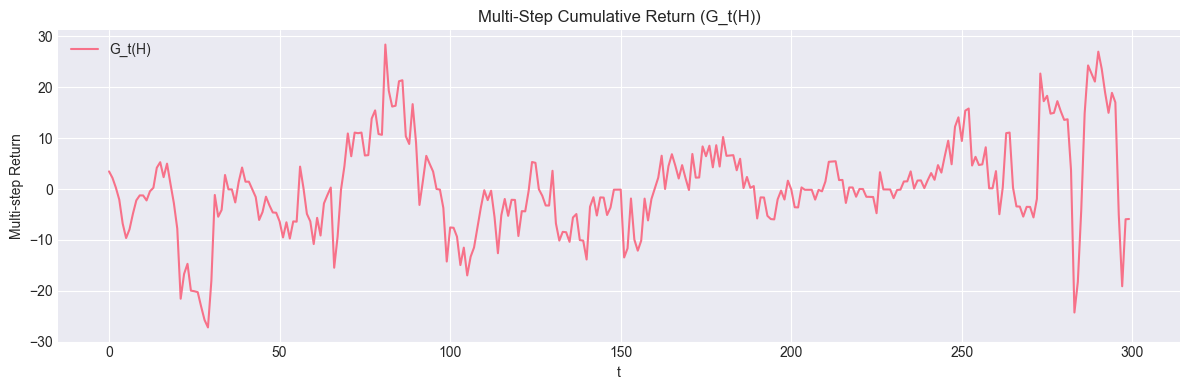

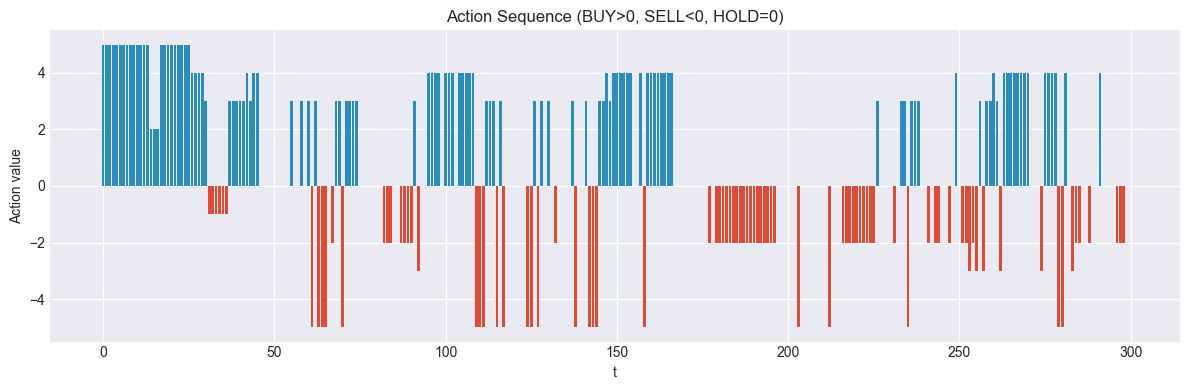


🔍 MSX Path ví dụ tại t=46 (WAITING -> ...):
  k=00 | price=2.31 pos=164.00 action=HOLD reward=1.6399999999998727
  k=01 | price=2.32 pos=164.00 action=HOLD reward=-1.6399999999998727
  k=02 | price=2.31 pos=164.00 action=HOLD reward=0.0
  k=03 | price=2.31 pos=164.00 action=HOLD reward=1.6399999999998727
  k=04 | price=2.32 pos=164.00 action=HOLD reward=-1.6399999999998727
  k=05 | price=2.31 pos=164.00 action=HOLD reward=0.0
  k=06 | price=2.31 pos=164.00 action=HOLD reward=0.0
  k=07 | price=2.31 pos=164.00 action=HOLD reward=-4.920000000000073
  k=08 | price=2.28 pos=164.00 action=HOLD reward=0.0
  k=09 | price=2.28 pos=164.00 action=BUY 3 reward=3.333159999999907
  k=10 | price=2.30 pos=167.00 action=HOLD reward=0.0

💾 Đã lưu kết quả giải thích vào msx_explanation_acb.csv


In [4]:
# 3. Chạy phân tích MSX cho trajectory đã mô phỏng
H = 10          # Horizon multi-step
gamma = 0.99    # Discount factor
step = 1        # Bước trượt
print(f"\n🚀 Bắt đầu giải thích trajectory với H={H}, gamma={gamma}...")
df_explain = explain_trajectory(states, actions, rewards, H=H, gamma=gamma, step=step)
print("✓ Hoàn tất sinh DataFrame giải thích.")
print(df_explain.head())

# Thống kê sơ bộ theo tags
tag_counts = df_explain['tags'].value_counts()
print("\n📌 Tag distribution:")
print(tag_counts)

# Vẽ multi-step returns và chuỗi actions
plot_multi_step_returns(df_explain, top_n=300)
plot_action_sequence(actions, top_n=300)

# Ví dụ: Lọc các đoạn WAITING chuyển sang BUY/SELL
waiting_indices = df_explain[df_explain['tags'].str.contains('WAITING')]['t'].tolist()
if waiting_indices:
    sample_t = waiting_indices[0]
    path_sample = build_decision_path(states, actions, rewards, sample_t, H)
    print(f"\n🔍 MSX Path ví dụ tại t={sample_t} (WAITING -> ...):")
    for i,(s,a,r) in enumerate(path_sample):
        price = price_at_state(s)
        pos = position_at_state(s)
        print(f"  k={i:02d} | price={price:.2f} pos={pos:.2f} action={interpret_action(a)} reward={r}")
else:
    print("\nKhông có đoạn WAITING được phát hiện.")

# Lưu kết quả nếu muốn
output_path = 'msx_explanation_acb.csv'
df_explain.to_csv(output_path, index=False)
print(f"\n💾 Đã lưu kết quả giải thích vào {output_path}")

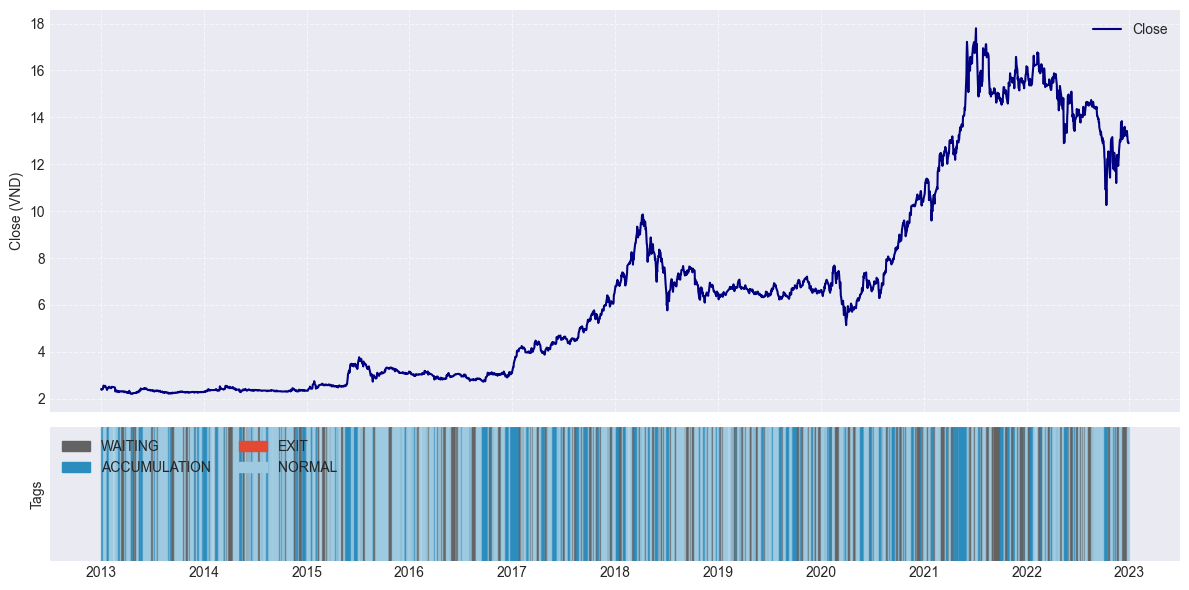

In [5]:
# 4. Biểu đồ timeline theo TAGs (WAITING, ACCUMULATION, EXIT)
import matplotlib.patches as mpatches

# Chuẩn bị dữ liệu tag theo thời gian
tag_primary = []
for _, row in df_explain.iterrows():
    # Lấy tag chính: ưu tiên EXIT > ACCUMULATION > WAITING > NORMAL
    tags = str(row['tags']).split(',') if pd.notna(row['tags']) else ['NORMAL']
    if 'EXIT' in tags:
        tag_primary.append('EXIT')
    elif 'ACCUMULATION' in tags:
        tag_primary.append('ACCUMULATION')
    elif 'WAITING' in tags:
        tag_primary.append('WAITING')
    else:
        tag_primary.append('NORMAL')

# Ánh xạ màu cho mỗi tag
tag_color = {
    'WAITING': '#636363',    # xám
    'ACCUMULATION': '#2b8cbe', # xanh
    'EXIT': '#e34a33',        # đỏ
    'NORMAL': '#9ecae1'       # xanh nhạt
}

# Lấy trục thời gian: dùng cột 'date' đã chuẩn bị từ df_processed
dates = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
T = min(len(dates), len(tag_primary))
dates = dates.iloc[:T]
tag_primary = tag_primary[:T]

# Vẽ 2 subplot: giá và tag timeline
fig, (ax_price, ax_tag) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios':[3,1]})

# Subplot 1: giá đóng cửa
ax_price.plot(dates, df_processed['close'].iloc[:T], color='navy', linewidth=1.5, label='Close')
# ax_price.set_title('ACB Price and Strategy Timeline')
ax_price.set_ylabel('Close (VND)')
ax_price.grid(True, linestyle='--', alpha=0.6)
ax_price.legend()

# Subplot 2: Tag timeline (mỗi bước tô màu theo tag)
for i in range(T-1):
    start = dates.iloc[i]
    end = dates.iloc[i+1]
    c = tag_color.get(tag_primary[i], '#9ecae1')
    ax_tag.axvspan(start, end, color=c, alpha=0.6)

ax_tag.set_yticks([])
ax_tag.set_ylabel('Tags')
ax_tag.grid(False)

# Legend patches
legend_handles = [
    mpatches.Patch(color=tag_color['WAITING'], label='WAITING'),
    mpatches.Patch(color=tag_color['ACCUMULATION'], label='ACCUMULATION'),
    mpatches.Patch(color=tag_color['EXIT'], label='EXIT'),
    mpatches.Patch(color=tag_color['NORMAL'], label='NORMAL'),
]
ax_tag.legend(handles=legend_handles, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()


🎯 Correctness distribution:
correctness
Neutral      1159
Incorrect     724
Correct       608
Name: count, dtype: int64


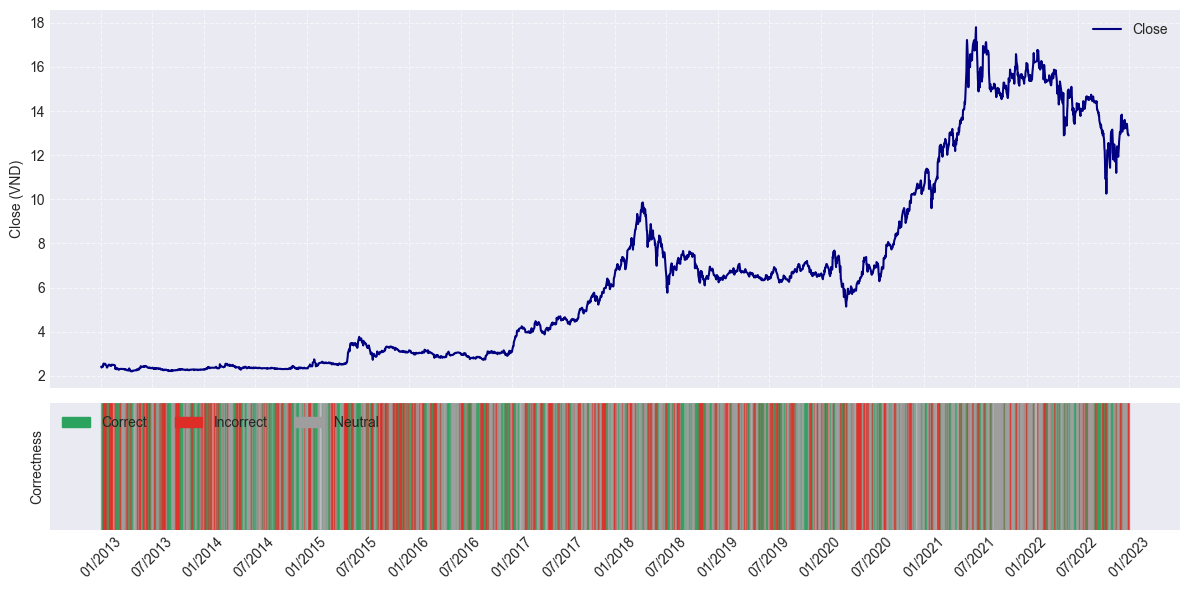

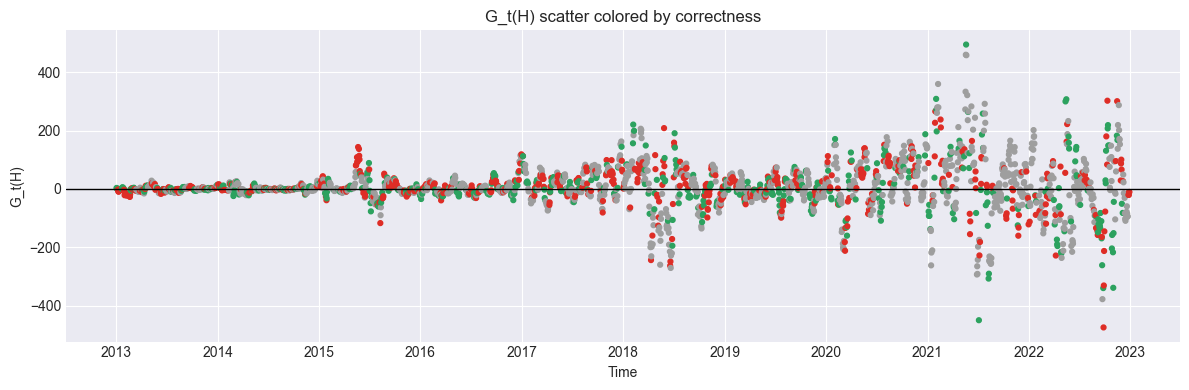

In [6]:
# 5. Biểu đồ đánh giá hành động đúng/sai so với dự đoán G_t(H)
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

# Quy tắc đánh giá đơn giản:
# - Nếu G_t(H) > threshold_pos: hành động BUY (>0) là 'Đúng', SELL (<0) là 'Sai'
# - Nếu G_t(H) < -threshold_neg: hành động SELL (<0) là 'Đúng', BUY (>0) là 'Sai'
# - Nếu |G_t(H)| <= threshold_zero: HOLD (==0) là 'Đúng', BUY/SELL là 'Sai'
# - Trường hợp còn lại: 'Khó xác định' (Neutral)
threshold_pos = 1e-6
threshold_neg = 1e-6
threshold_zero = 1e-6

def classify_correctness(a: int, G: float) -> str:
    if a is None:
        return 'Neutral'
    if G > threshold_pos:
        return 'Correct' if a > 0 else 'Incorrect' if a < 0 else 'Neutral'
    elif G < -threshold_neg:
        return 'Correct' if a < 0 else 'Incorrect' if a > 0 else 'Neutral'
    else:
        # near zero expected return -> HOLD preferred
        return 'Correct' if a == 0 else 'Incorrect'

# Tạo cột đánh giá trong df_explain
df_explain['correctness'] = [classify_correctness(a, g) for a, g in zip(df_explain['action'], df_explain['G_t(H)'])]

# Thống kê
print('\n🎯 Correctness distribution:')
print(df_explain['correctness'].value_counts())

# Vẽ timeline bands theo correctness
corr_color = {
    'Correct': '#2ca25f',    # xanh lá
    'Incorrect': '#de2d26',  # đỏ
    'Neutral': '#9e9e9e'     # xám
}

dates = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
T = min(len(dates), len(df_explain))
dates = dates.iloc[:T]
df_corr = df_explain.iloc[:T].copy()

fig, (ax_price, ax_corr) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios':[3,1]})
ax_price.plot(dates, df_processed['close'].iloc[:T], color='navy', linewidth=1.5, label='Close')
# ax_price.set_title('Action Correctness vs Predicted Multi-Step Return G_t(H)')
ax_price.set_ylabel('Close (VND)')
ax_price.grid(True, linestyle='--', alpha=0.6)
ax_price.legend()

for i in range(T-1):
    start = dates.iloc[i]
    end = dates.iloc[i+1]
    ctag = df_corr.iloc[i]['correctness']
    c = corr_color.get(ctag, '#9e9e9e')
    ax_corr.axvspan(start, end, color=c, alpha=0.5)

ax_corr.set_yticks([])
ax_corr.set_ylabel('Correctness')
ax_corr.grid(False)

legend_handles = [
    mpatches.Patch(color=corr_color['Correct'], label='Correct'),
    mpatches.Patch(color=corr_color['Incorrect'], label='Incorrect'),
    mpatches.Patch(color=corr_color['Neutral'], label='Neutral'),
]
ax_corr.legend(handles=legend_handles, loc='upper left', ncol=3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tùy chọn: scatter trực tiếp G_t(H) với mã màu theo correctness
plt.figure(figsize=(12,4))
colors = [corr_color[c] for c in df_explain['correctness'].iloc[:T]]
plt.scatter(dates, df_explain['G_t(H)'].iloc[:T], c=colors, s=12)
plt.axhline(0, color='black', linewidth=1)
plt.title('G_t(H) scatter colored by correctness')
plt.ylabel('G_t(H)')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Overall Correct: 45.65% | Incorrect: 54.35%


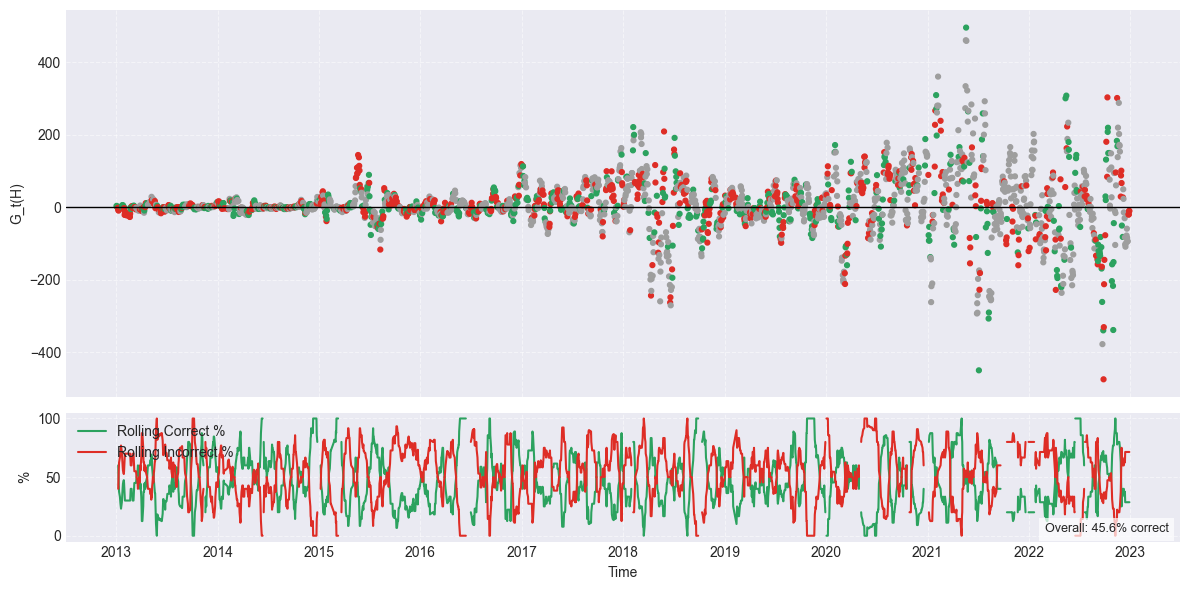

In [7]:
# 6. Phần trăm đúng/sai (rolling và tổng quan)
# Tạo mã số cho correctness
corr_map = {'Correct':1, 'Incorrect':0, 'Neutral':np.nan}
corr_series = df_explain['correctness'].map(corr_map)

# Rolling window để tính phần trăm đúng/sai theo thời gian
window = 20  # có thể chỉnh
rolling_correct_pct = corr_series.rolling(window=window, min_periods=5).mean()*100
rolling_incorrect_pct = (1 - corr_series.rolling(window=window, min_periods=5).mean())*100
dates = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
T = min(len(dates), len(df_explain))
dates = dates.iloc[:T]
rolling_correct_pct = rolling_correct_pct.iloc[:T]
rolling_incorrect_pct = rolling_incorrect_pct.iloc[:T]

# Tổng quan phần trăm toàn bộ
valid = corr_series.dropna()
overall_correct_pct = float(valid.mean()*100) if len(valid)>0 else 0.0
overall_incorrect_pct = 100.0 - overall_correct_pct

print(f"Overall Correct: {overall_correct_pct:.2f}% | Incorrect: {overall_incorrect_pct:.2f}%")

# Vẽ subplot nhỏ phía dưới
fig, (ax_main, ax_small) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios':[3,1]})

# Trên: scatter G_t(H) theo correctness (tái dùng)
colors = {'Correct':'#2ca25f','Incorrect':'#de2d26','Neutral':'#9e9e9e'}
color_list = [colors[c] for c in df_explain['correctness'].iloc[:T]]
ax_main.scatter(dates, df_explain['G_t(H)'].iloc[:T], c=color_list, s=12)
ax_main.axhline(0, color='black', linewidth=1)
# ax_main.set_title('G_t(H) scatter and rolling correctness %')
ax_main.set_ylabel('G_t(H)')
ax_main.grid(True, linestyle='--', alpha=0.5)

# Dưới: phần trăm đúng/sai rolling
ax_small.plot(dates, rolling_correct_pct, color='#2ca25f', label='Rolling Correct %')
ax_small.plot(dates, rolling_incorrect_pct, color='#de2d26', label='Rolling Incorrect %')
ax_small.set_ylabel('%')
ax_small.set_xlabel('Time')
ax_small.grid(True, linestyle='--', alpha=0.5)
ax_small.legend(loc='upper left')

# Thêm text tổng quan
ax_small.text(0.99, 0.05, f"Overall: {overall_correct_pct:.1f}% correct", transform=ax_small.transAxes, ha='right', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()